<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo on simulation data

## Load packages

In [1]:
%cd ../RADOM

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from inference import Trajectory
from plotting import *
from models.two_species_ss import get_Y

/home/mffang/workspace/Poisson-regression/RADOM


In [2]:
from scipy.stats import spearmanr
import anndata as ad
import velocyto as vcy
import scvelo as scv
import scanpy as sc

In [3]:
def getNeighbors(embed, n_neigh=100, p=1):
    """Get indices of nearest neighbors in embedding (shape n_samples,n_features)"""
    nbrs = NearestNeighbors(n_neighbors=n_neigh, p=p).fit(embed)
    distances, indices = nbrs.kneighbors(embed)
    return indices

def getJaccard(x1, x2, n_neigh=100, p=1):
    '''
    Get jaccard distance between embeddings
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    assert len(x1.shape) == 2
    assert len(x2.shape) == 2
    embed1_neighbor = getNeighbors(x1,n_neigh,p=p)
    embed2_neighbor = getNeighbors(x2,n_neigh,p=p)
    frac = [0]*embed1_neighbor.shape[0]
    for i in range(embed1_neighbor.shape[0]):
        inter = set(embed1_neighbor[i,:]).intersection(embed2_neighbor[i,:])
        union = set(embed1_neighbor[i,:]).union(embed2_neighbor[i,:])
        frac[i] = 1-len(inter)/len(union)
    return frac


## Generate data

In [4]:
def simulate_data(topo, tau, n, p, loga_max=4, logb_mu=1, logb_sd=1, random_seed=2023, loomfilepath=None):    
    np.random.seed(random_seed)
    L=len(topo)
    K=len(tau)-1
    n_states=len(set(topo.flatten()))
    t=np.linspace(tau[0],tau[-1],n)
    true_t = []
    
    theta=np.zeros((p,n_states+2))
    for j in range(n_states):
        theta[:,j]=np.exp(np.random.uniform(0,loga_max,size=p))-1
    theta[:,-2:]=np.exp(np.random.normal(logb_mu,logb_sd,size=(p,2)))

    Y = np.zeros((n*L,p,2))
    for l in range(L):
        theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
        Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2
        true_t = np.append(true_t,t)
   
    X = np.random.poisson(Y)
    
    if loomfilepath is not None:
        adata=ad.AnnData(np.sum(X,axis=-1))
        adata.layers["spliced"] = X[:,:,1]
        adata.layers["unspliced"] = X[:,:,0]
        adata.layers["ambiguous"]=np.zeros_like(X[:,:,0])
        adata.obs["time"]=true_t
        adata.obs["celltype"]=np.arange(n*L)//n
        adata.uns["theta"]=theta
        adata.var["true_beta"]=theta[:,-2]
        adata.var["true_gamma"]=theta[:,-1]
        adata.write_loom(loomfilepath)
    return theta, true_t, Y, X,

In [5]:
#%% generate data
topo=np.array([[0,1]])
tau=(0,1)
true_theta, true_t, Y, X = simulate_data(topo,tau,n=2000,p=200,random_seed=2023,loomfilepath="../data/simulation.loom")

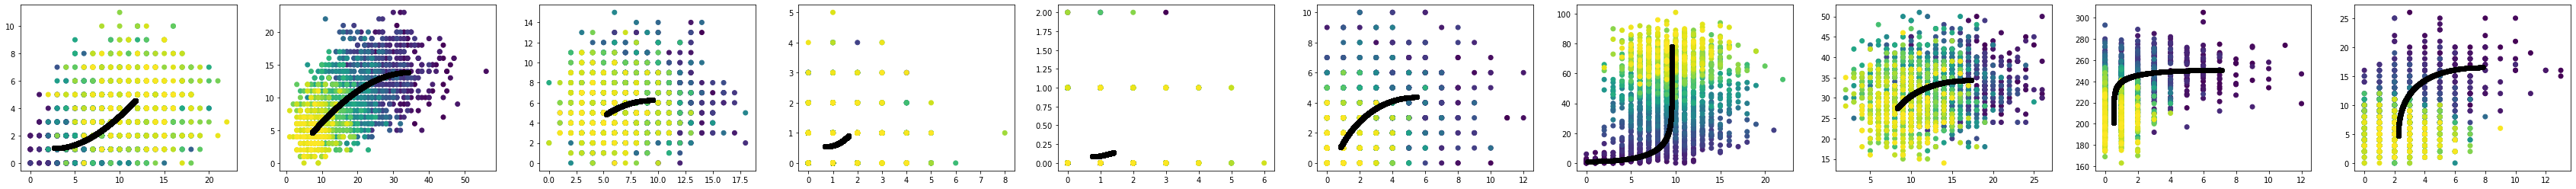

In [6]:
fig, ax = plt.subplots(1,10,figsize=(6*10,4))
for i in range(10):
    #ax[i].plot(Y[:,i,1]*gamma[i],Y[:,i,1],'--', color='gray');
    ax[i].scatter(X[:,i,0],X[:,i,1],c=true_t);
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c='black');
# time increases from blue to red

In [7]:
traj = Trajectory(topo,tau,model="two_species_ss")
traj = traj.fit(X,n_init=5,epoch=10,parallel=True,n_threads=10)

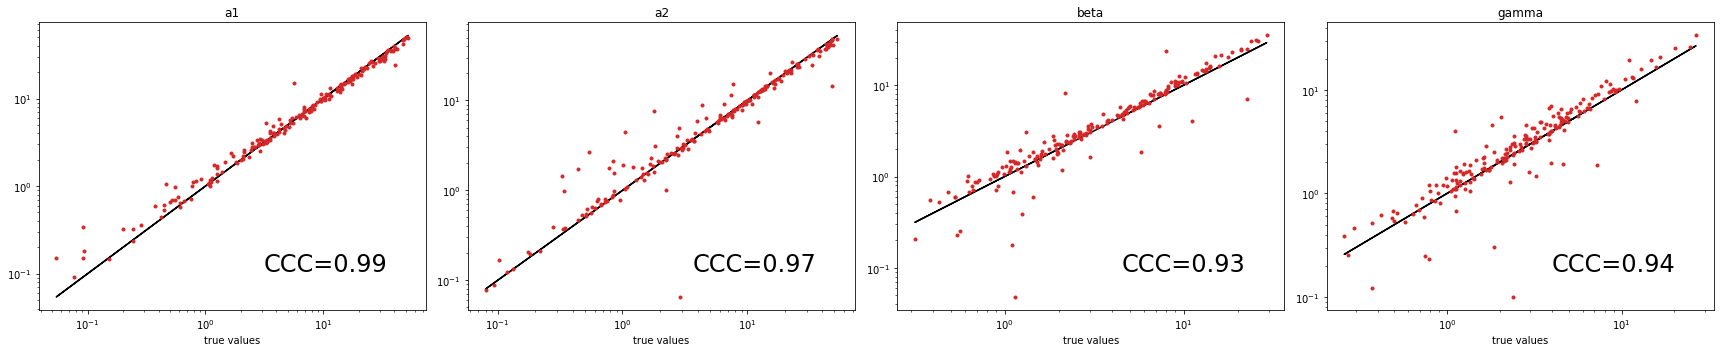

In [8]:
plot_theta(true_theta,traj.theta);

<AxesSubplot:>

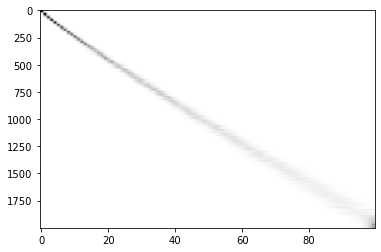

In [9]:
plot_t(traj)

Text(0.5, 1.0, 'Spearman cor:0.999')

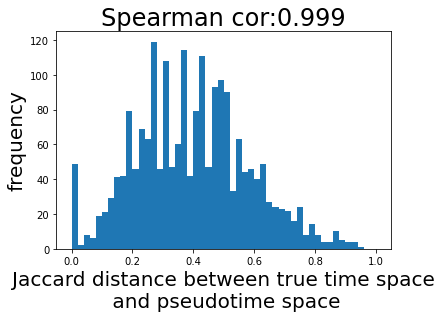

In [10]:
x1=true_t
x2=traj.Q[:,0]@traj.t
frac = getJaccard(x1.reshape((-1,1)), x2.reshape((-1,1)), n_neigh=100, p=1)
plt.hist(frac,np.linspace(0,1,51))
plt.xlabel("Jaccard distance between true time space\n and pseudotime space",fontsize=20)
plt.ylabel("frequency",fontsize=20)
plt.title("Spearman cor:"+str(np.round(spearmanr(x1,x2)[0],3)),fontsize=24)

Text(0, 0.5, 'frequency')

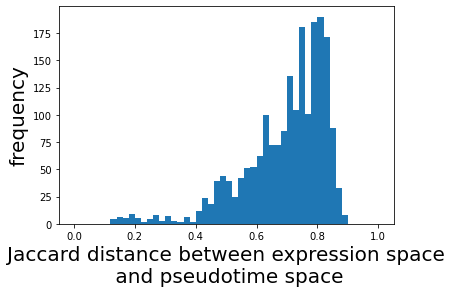

In [11]:
x1=np.append(X[:,:,0],X[:,:,1],axis=1)
x2=traj.Q[:,0]@traj.t
frac = getJaccard(x1, x2.reshape((-1,1)), n_neigh=100, p=1)
plt.hist(frac,np.linspace(0,1,51))
plt.xlabel("Jaccard distance between expression space\n and pseudotime space",fontsize=20)
plt.ylabel("frequency",fontsize=20)
#plt.title("Spearman cor:"+str(np.round(spearmanr(x1,x2)[0],3)),fontsize=24)

# 1d neighbors

Text(0.5, 1.0, 'Jaccard distance in L1')

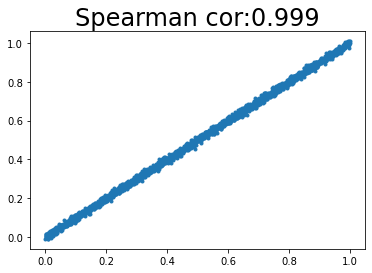

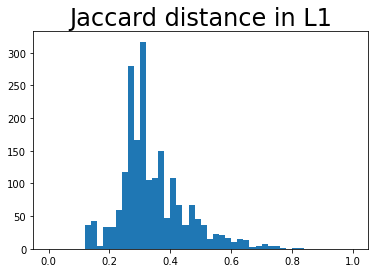

In [85]:
x2=true_t+np.random.normal(0,0.01,size=len(X))
x1=true_t
plt.plot(x1,x2,'.');
plt.title("Spearman cor:"+str(np.round(spearmanr(x1,x2)[0],3)),fontsize=24)
frac = getJaccard(x1=x1, x2=x2, n_neigh=100, p=1)
plt.figure()
plt.hist(frac,np.linspace(0,1,51))
plt.title("Jaccard distance in L1",fontsize=24)

# scanpy

In [13]:
adata = sc.read("../data/simulation.loom")
sc.pp.recipe_zheng17(adata,n_top_genes=200)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)

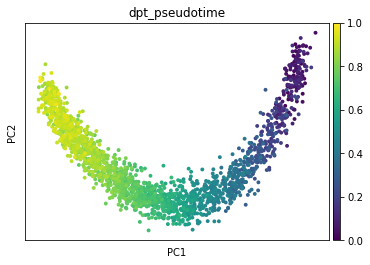

In [14]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['time']  == 0)[0]
sc.tl.dpt(adata)
sc.pl.pca(adata, color=['dpt_pseudotime'], legend_loc='on data')

Text(0.5, 1.0, 'Spearman cor:0.976')

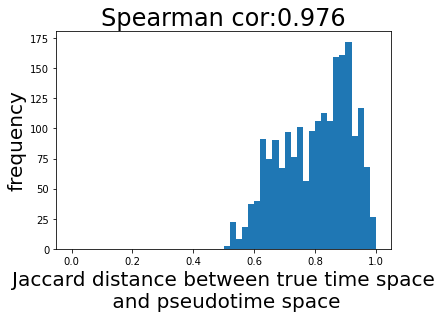

In [15]:
x1=true_t
x2=np.array(adata.obs['dpt_pseudotime'])
frac = getJaccard(x1.reshape((-1,1)), x2.reshape((-1,1)), n_neigh=100, p=1)
plt.hist(frac,np.linspace(0,1,51))
plt.xlabel("Jaccard distance between true time space\n and pseudotime space",fontsize=20)
plt.ylabel("frequency",fontsize=20)
plt.title("Spearman cor:"+str(np.round(spearmanr(x1,x2)[0],3)),fontsize=24)

Text(0, 0.5, 'frequency')

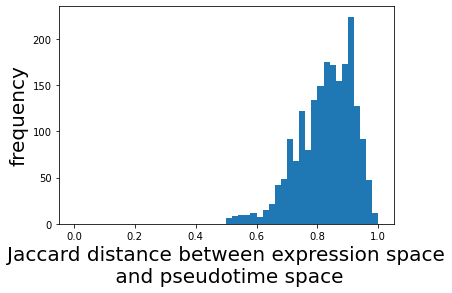

In [17]:
x1=np.append(X[:,:,0],X[:,:,1],axis=1)
x2=np.array(adata.obs['dpt_pseudotime'])
frac = getJaccard(x1, x2.reshape((-1,1)), n_neigh=100, p=1)
plt.hist(frac,np.linspace(0,1,51))
plt.xlabel("Jaccard distance between expression space\n and pseudotime space",fontsize=20)
plt.ylabel("frequency",fontsize=20)
#plt.title("Spearman cor:"+str(np.round(spearmanr(x1,x2)[0],3)),fontsize=24)

Text(0, 0.5, 'frequency')

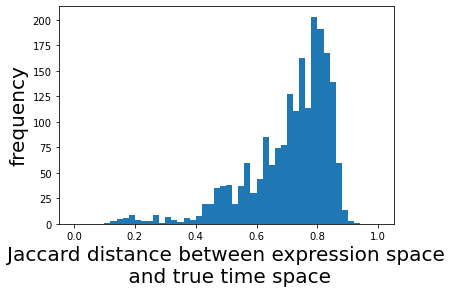

In [19]:
x1=np.append(X[:,:,0],X[:,:,1],axis=1)
x2=true_t
frac = getJaccard(x1, x2.reshape((-1,1)), n_neigh=100, p=1)
plt.hist(frac,np.linspace(0,1,51))
plt.xlabel("Jaccard distance between expression space\n and true time space",fontsize=20)
plt.ylabel("frequency",fontsize=20)
#plt.title("Spearman cor:"+str(np.round(spearmanr(x1,x2)[0],3)),fontsize=24)

## velocyto

In [26]:
def run_velocyto(loomfile,quiver_scale="auto"):
    vlm = vcy.VelocytoLoom(loomfile)
    vlm.normalize()
    vlm.perform_PCA()
    vlm.knn_imputation()
    vlm.fit_gammas()
    vlm.normalize(which="imputed", size=False, log=True)
    vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")
    vlm.predict_U()
    vlm.calculate_velocity()
    vlm.calculate_shift(assumption="constant_velocity")
    vlm.extrapolate_cell_at_t(delta_t=1.)
    vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="sqrt")
    vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)
    vlm.calculate_grid_arrows(smooth=0.5, steps=(25, 25))
    fig = plt.figure(figsize=(12,4))
    fig.add_subplot(121)
    vlm.colorandum = vlm.ca["time"]
    vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},quiver_scale=quiver_scale)
    fig.add_subplot(122)
    plt.plot(vlm.ra["true_gamma"]/vlm.ra["true_beta"],vlm.gammas,'.');
    plt.plot(vlm.ra["true_gamma"]/vlm.ra["true_beta"],vlm.ra["true_gamma"]/vlm.ra["true_beta"],'r-');
    plt.xscale('log')
    plt.yscale('log')

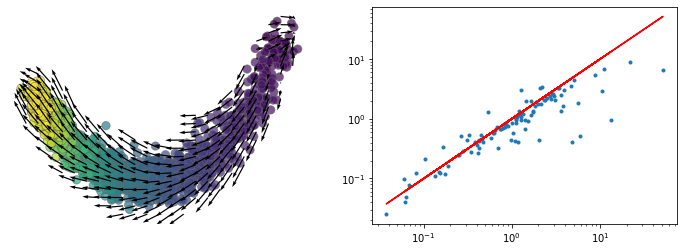

In [27]:
run_velocyto("../data/simulation.loom", quiver_scale=0.1)

## scvelo

In [ ]:
def run_scvelo(loomfile,dynamical=False,cores=4):
    adata = scv.read_loom(loomfile)
    scv.pp.filter_and_normalize(adata, min_shared_counts=0, n_top_genes=1000)
    scv.pp.moments(adata)
    if dynamical:
        scv.tl.recover_dynamics(adata,n_jobs=cores)
        scv.tl.velocity(adata, mode='dynamical')
    else:
        scv.tl.velocity(adata)

    scv.tl.velocity_graph(adata,basis='pca')
    scv.pl.velocity_embedding_stream(adata, color=t,basis='pca')

    idx = adata.var['velocity_genes']
    if dynamical:
        true_gamma = adata.var['gamma']
        true_beta = adata.var['beta']
        betas = adata.var['fit_beta']
        gammas = adata.var['fit_gamma']
        fig, ax = plt.subplots(1,2,figsize=(12,4))
        ax[0].plot(true_beta[idx],betas[idx],'.');
        ax[0].plot(true_beta[idx],true_beta[idx],'r-');
        ax[1].plot(true_gamma[idx],gammas[idx],'.');
        ax[1].plot(true_gamma[idx],true_gamma[idx],'r-');
    else:
        true_gamma = adata.var['gamma']/adata.var['beta']
        gammas = adata.var['velocity_gamma']
        plt.plot(true_gamma[idx],gammas[idx],'.');
        plt.plot(true_gamma[idx],true_gamma[idx],'r-');
    
    plt.xscale('log')
    plt.yscale('log')
    return adata
  

In [ ]:
run_scvelo("data/simulation.loom",dynamical=False)

In [ ]:
run_scvelo("data/simulation.loom",dynamical=True)

## dynamo

In [36]:
def run_dynamo(loomfile,basis='pca'):
    adata = dyn.read_loom(loomfile)
    dyn.pp.recipe_monocle(adata)
    dyn.tl.dynamics(adata)
    dyn.tl.reduceDimension(adata, basis=basis, enforce=True)
    dyn.tl.cell_velocities(adata, basis=basis)
    dyn.pl.streamline_plot(adata, color=["time"], basis=basis)
    dyn.vf.VectorField(adata, basis=basis)
    dyn.pl.topography(adata, basis=basis,fps_basis=basis)
    true_gamma = adata.var['true_gamma']/adata.var['true_beta']
    gammas = adata.var['gamma']
    plt.plot(true_gamma,gammas,'.');
    plt.plot(true_gamma,true_gamma,'r-');
    plt.xscale('log')
    plt.yscale('log')

### pca

In [35]:
run_dynamo("data/simulation_20.loom",basis='pca')

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['



estimating gamma: 100%|██████████| 20/20 [00:00<00:00, 350.86it/s]

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...


|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [18.3775s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----? Only less than 5 genes satisfies transition gene selection criteria, which may be resulted from: 
  1. Very low intron/new RNA ratio, tr

ValueError: adata.var.use_for_transition does not have enough values that are not NA.

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['

estimating gamma: 100%|██████████| 2000/2000 [01:24<00:00, 23.74it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [20.0492s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|

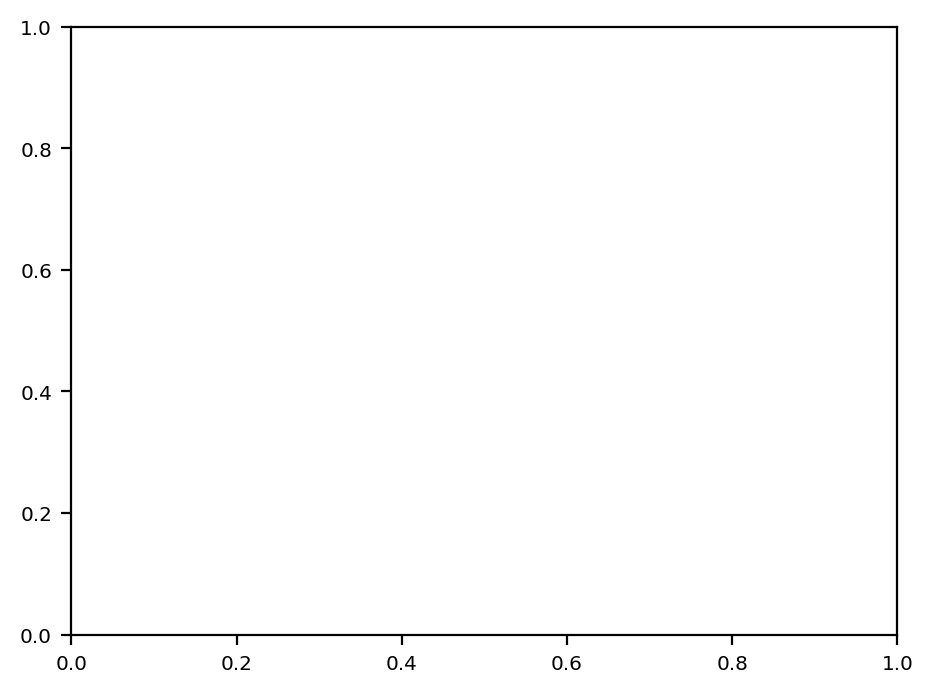

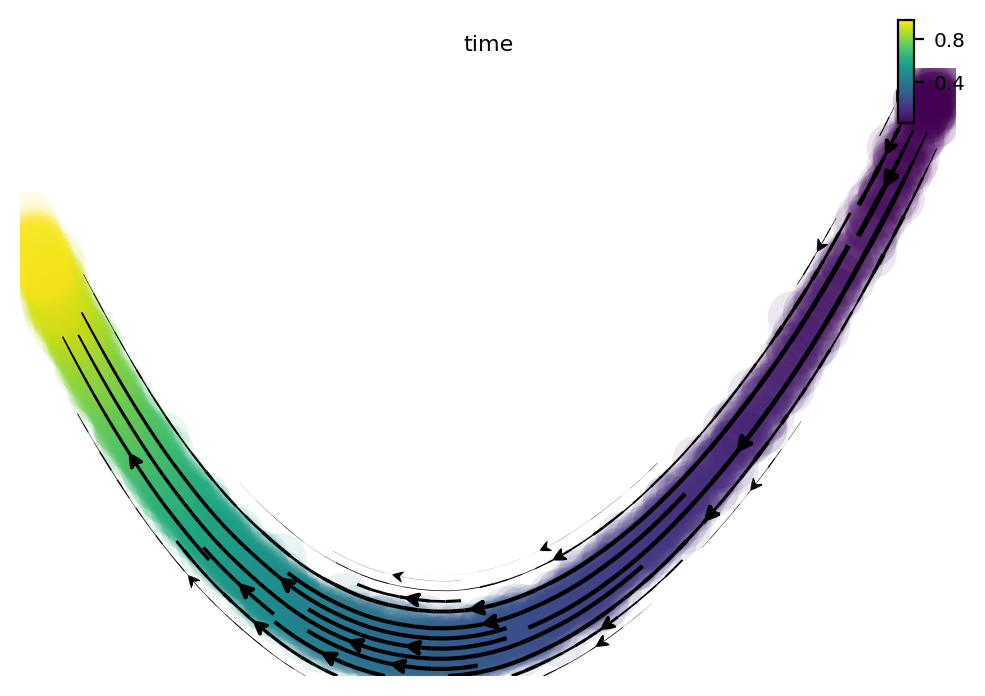

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.1857s]
|-----> <insert> velocity_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_pca to uns in AnnData Object.
|-----> <insert> control_point_pca to obs in AnnData Object.
|-----> <insert> inlier_prob_pca to obs in AnnData Object.
|-----> <insert> obs_vf_angle_pca to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [0.3955s]
|-----> Vector field for pca is but its topography is not mapped. Mapping topography now ...
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on 

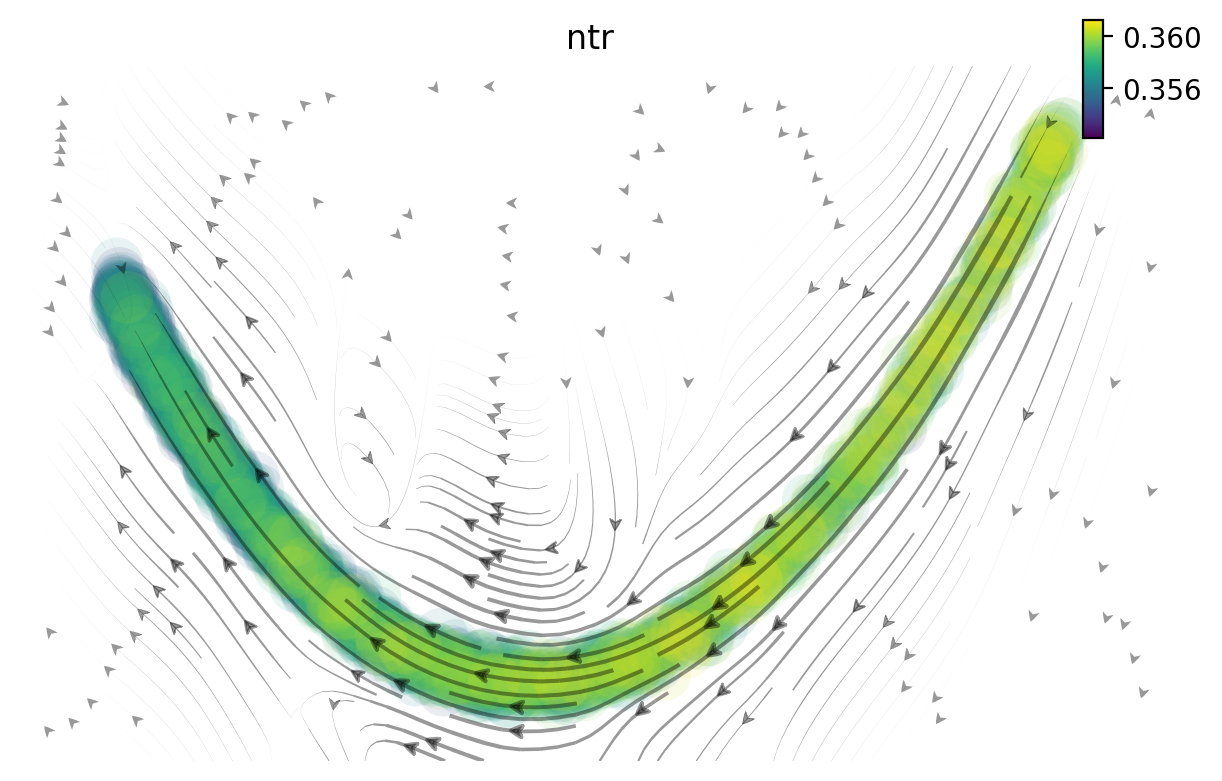

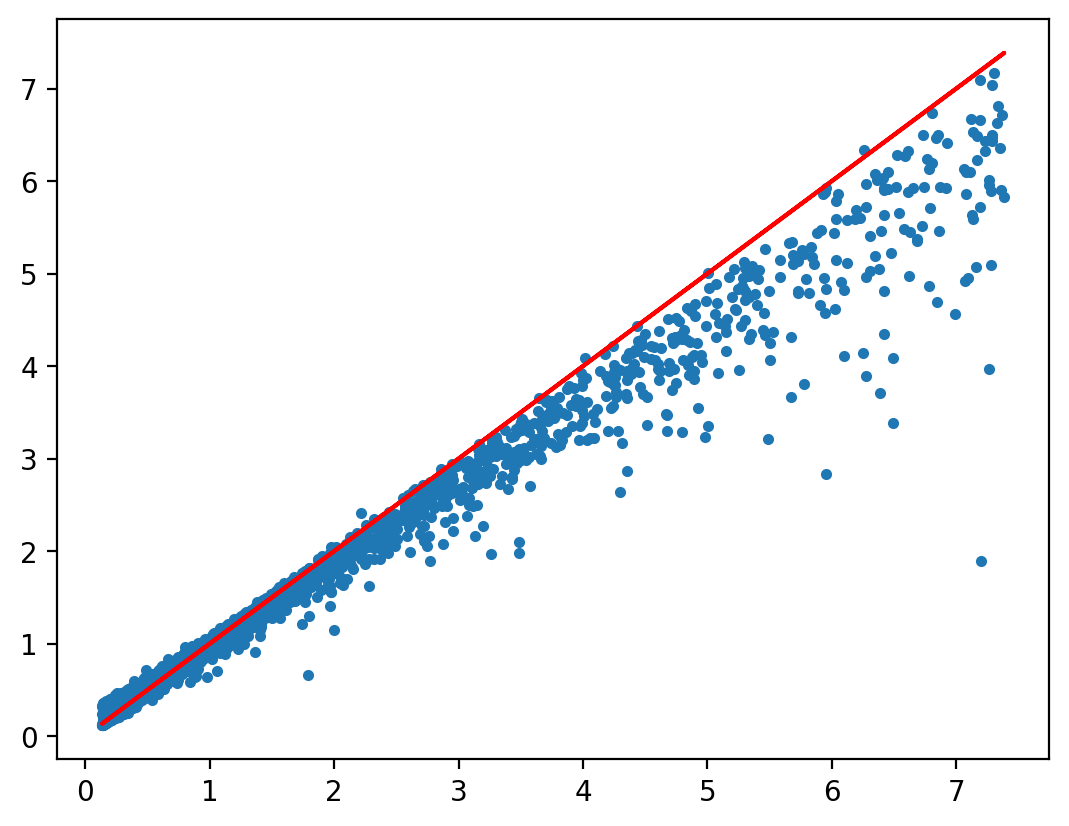

In [ ]:
run_dynamo("data/simulation_2000.loom",basis='pca')

### umap

In [ ]:
run_dynamo("data/simulation_20.loom",basis='umap')

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['

estimating gamma: 100%|██████████| 15/15 [00:00<00:00, 283.38it/s]

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...


|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [20.5576s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----? Only less than 5 genes satisfies transition gene selection criteria, which may be resulted from: 
  1. Very low intron/new RNA ratio, tr

ValueError: ignored

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['



estimating gamma:   0%|          | 0/1000 [00:00<?, ?it/s]

estimating gamma:   1%|          | 9/1000 [00:00<00:12, 81.06it/s]

estimating gamma:   2%|▏         | 18/1000 [00:00<00:12, 79.66it/s]

estimating gamma:   3%|▎         | 26/1000 [00:00<00:17, 57.07it/s]

estimating gamma:   3%|▎         | 34/1000 [00:00<00:15, 62.33it/s]

estimating gamma:   4%|▍         | 42/1000 [00:00<00:14, 66.76it/s]

estimating gamma:   5%|▌         | 50/1000 [00:00<00:13, 69.76it/s]

estimating gamma:   6%|▌         | 58/1000 [00:00<00:13, 71.85it/s]

estimating gamma:   7%|▋         | 66/1000 [00:01<00:15, 59.88it/s]

estimating gamma:   7%|▋         | 73/1000 [00:01<00:15, 59.44it/s]

estimating gamma:   8%|▊         | 81/1000 [00:01<00:14, 62.96it/s]

estimating gamma:   9%|▉         | 89/1000 [00:01<00:13, 65.88it/s]

estimating gamma:  10%|▉         | 97/1000 [00:01<00:13, 68.15it/s]

estimating gamma:  10%|█         | 104/1000 [00:01<00:14, 60.79it/s]

estimating gamma:  11%|█         | 111/10

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [15.7959s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|

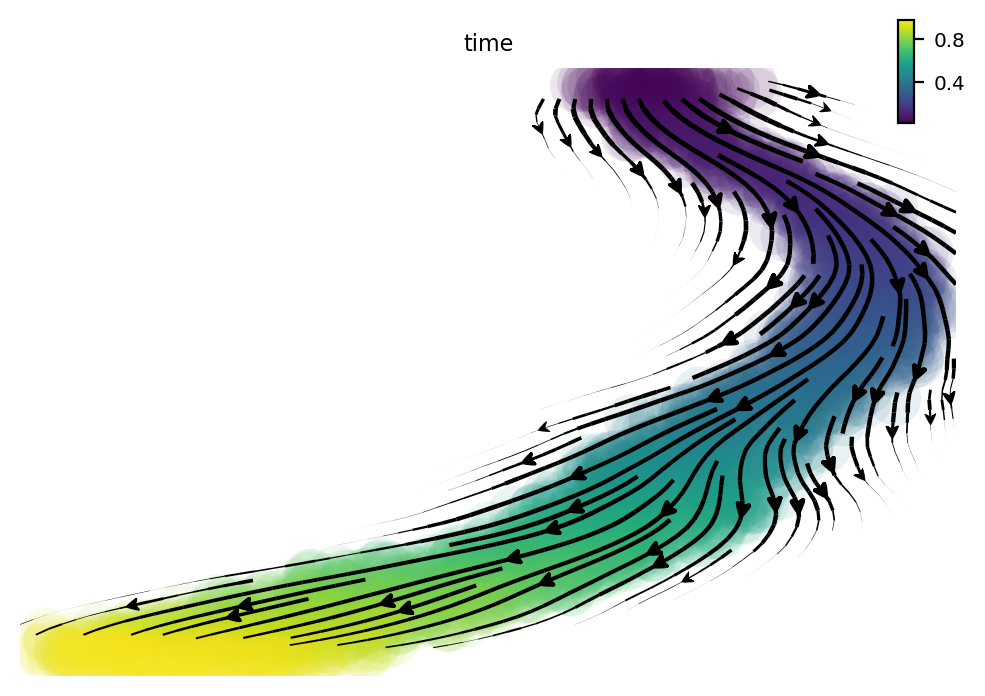

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.3339s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_umap to uns in AnnData Object.
|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <insert> inlier_prob_umap to obs in AnnData Object.
|-----> <insert> obs_vf_angle_umap to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [0.4874s]
|-----> Vector field for umap is but its topography is not mapped. Mapping topography now .

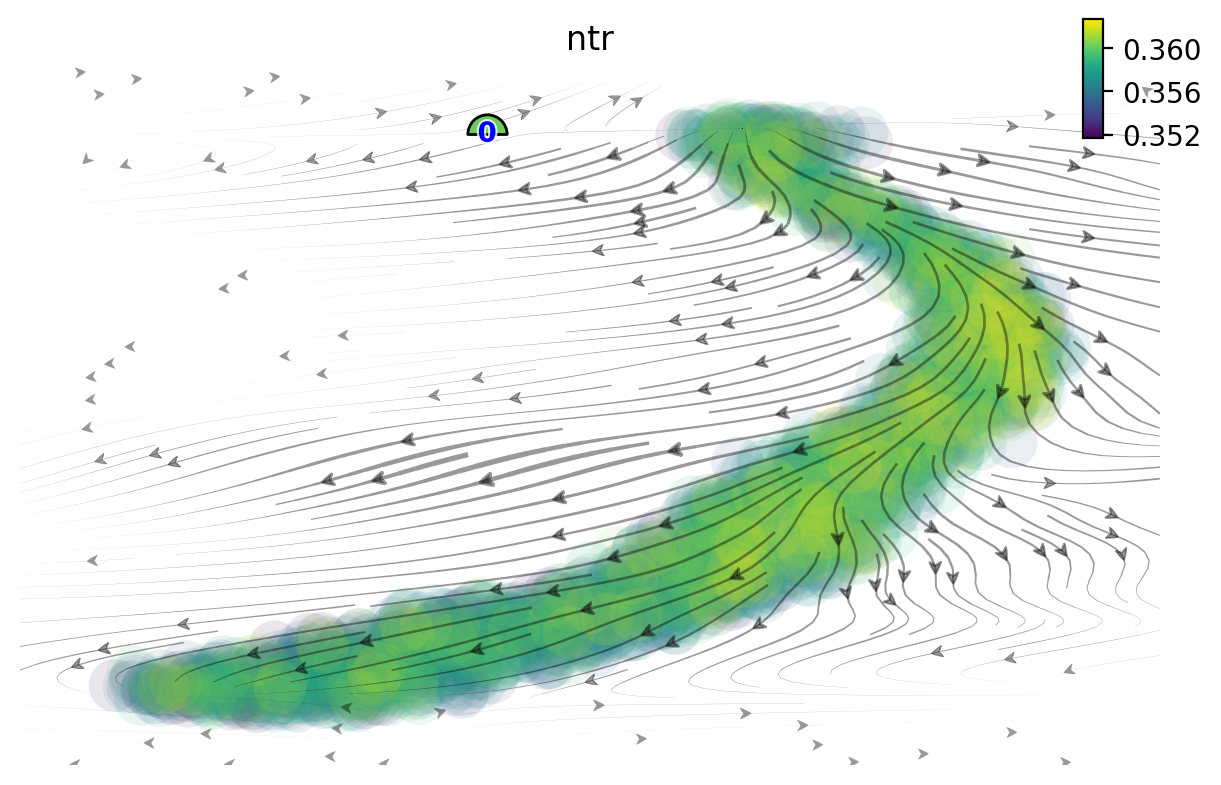

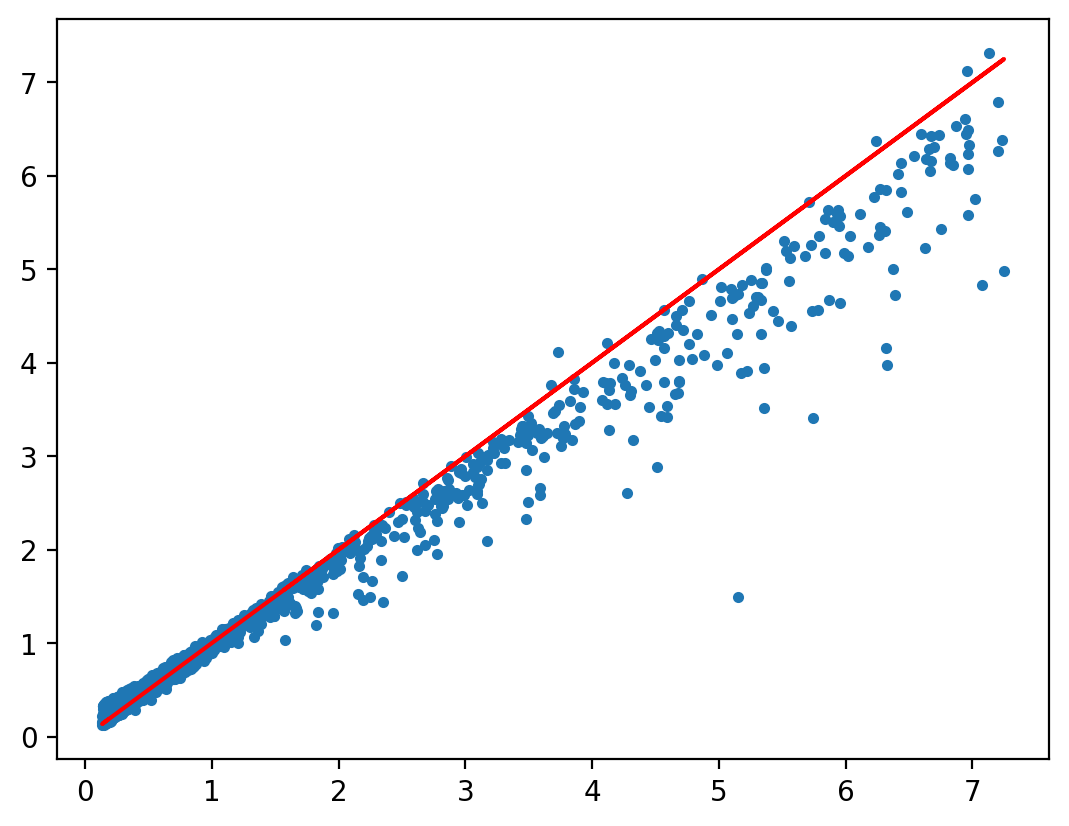

In [37]:
run_dynamo("data/simulation_1000.loom",basis='umap')

# CEM vs EM

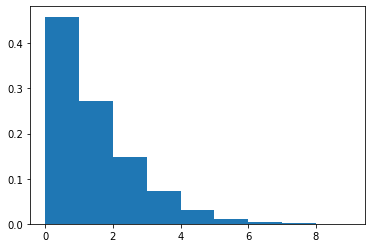

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N=100000
c=0.2
z=np.random.uniform(0,10,size=N)
y=np.random.poisson(z)
x=np.random.poisson(c*y)
plt.hist(x,bins=np.arange(0,10),density=True);

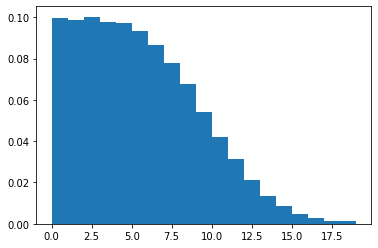

In [ ]:
plt.hist(y,bins=np.arange(0,20),density=True);

In [ ]:
def CEM_Q(theta,x):
    eps=1e-100
    h=np.linspace(0,theta,100)[None,:]
    ll=x[:,None]*np.log(h+eps)-h
    Q = np.mean(np.amax(ll,axis=1))
    return Q

In [ ]:
n=51
thetas = np.linspace(1,5,n)
Qs = np.zeros(n)
for i in range(n):
    Qs[i]=CEM_Q(thetas[i],x)

5.0


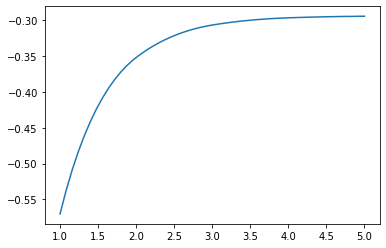

In [ ]:
plt.plot(thetas,Qs)
idx = np.argmax(Qs)
print(thetas[idx])

In [ ]:
from scipy.special import softmax

def EM_Q(theta,x):
    eps=1e-100
    h=np.linspace(0,theta,100)
    h=h[None,:]
    ll=x[:,None]*np.log(h+eps)-h
    q=softmax(ll,axis=1)
    Q=np.mean(np.sum(q*ll-q*np.log(q+eps),axis=1))
    return Q

In [ ]:
n=21
thetas = np.linspace(1.9,2.1,n)
Qs = np.zeros(n)
for i in range(n):
    Qs[i]=EM_Q(thetas[i],x)

2.0300000000000002


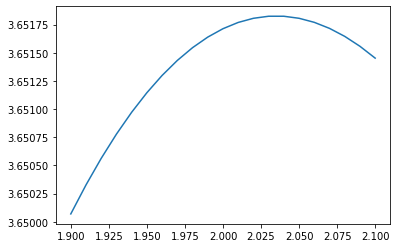

In [ ]:
plt.plot(thetas,Qs)
idx = np.argmax(Qs)
print(thetas[idx])

In [ ]:
n=21
thetas = np.linspace(9.9,10.1,n)
Qs = np.zeros(n)
for i in range(n):
    Qs[i]=EM_Q(thetas[i],y)

10.02


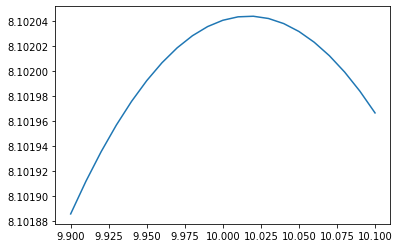

In [ ]:
plt.plot(thetas,Qs)
idx = np.argmax(Qs)
print(thetas[idx])

# Toggle switch

\begin{align}
&\frac{du_1}{dt} = \frac{\alpha_1}{1 + (s_3/k_1)^n} - \beta_1 u_1,\\[1em]
&\frac{ds_1}{dt} = \beta_1 u_1 - \gamma_1 s_1,\\[1em]
&\frac{du_2}{dt} = \frac{\alpha_2}{1 + (s_1/k_1)^n} - \beta_2 u_2,\\[1em]
&\frac{ds_2}{dt} = \beta_2 u_2 - \gamma_2 s_2,\\[1em]
&\frac{du_2}{dt} = \frac{\alpha_3}{1 + (s_3/k_1)^n} - \beta_3 u_3,\\[1em]
&\frac{ds_2}{dt} = \beta_3 u_3 - \gamma_2 s_3.
\end{align}

In [3]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

In [43]:
def repressilator(t, y, alpha_1, alpha_2, alpha_3, beta_1, beta_2, beta_3, gamma_1, gamma_2, gamma_3, k, n): 
    u_1, s_1, u_2, s_2, u_3, s_3  = y
    du_1_dt = alpha_1/(1 + (s_3/k)**n) - beta_1 * u_1
    ds_1_dt = beta_1 * u_1 - gamma_1 * s_1
    du_2_dt = alpha_2/(1 + (s_1/k)**n) - beta_2 * u_2
    ds_2_dt = beta_2 * u_2 - gamma_2 * s_2
    du_3_dt = alpha_3/(1 + (s_1/k)**n) - beta_3 * u_3
    ds_3_dt = beta_3 * u_3 - gamma_3 * s_3

    return [du_1_dt, ds_1_dt, du_2_dt, ds_2_dt, du_3_dt, ds_3_dt]

In [72]:
def toggle_switch(t, y, alpha_1, alpha_2, beta_1, beta_2, gamma_1, gamma_2, k, n): 
    u_1, s_1, u_2, s_2 = y
    du_1_dt = alpha_1/(1 + (s_2/k)**n) - beta_1 * u_1
    ds_1_dt = beta_1 * u_1 - gamma_1 * s_1
    du_2_dt = alpha_2/(1 + (s_1/k)**n) - beta_2 * u_2
    ds_2_dt = beta_2 * u_2 - gamma_2 * s_2

    return [du_1_dt, ds_1_dt, du_2_dt, ds_2_dt]

In [18]:
def piecewise(t, y, alpha_1, alpha_2, beta_1, beta_2, gamma_1, gamma_2, k_1, k_2, n): 
    u_1, s_1, u_2, s_2 = y
    if t>0.03:
        alpha_1 = 0.032
    """ 
    if (s_2/k_1)**n > 1:
    alpha_1 = 0
    if (s_1/k_2)**n > 1:
    alpha_2 = 0
    """
    du_1_dt = alpha_1 - beta_1 * u_1
    ds_1_dt = beta_1 * u_1 - gamma_1 * s_1
    du_2_dt = alpha_2 - beta_2 * u_2
    ds_2_dt = beta_2 * u_2 - gamma_2 * s_2

    return [du_1_dt, ds_1_dt, du_2_dt, ds_2_dt]

In [73]:
# Parameters
alpha_1 = 100
alpha_2 = 100
alpha_3 = 100
beta_1 = 10
beta_2 = 10
beta_3 = 10
gamma_1 = 10
gamma_2 = 10
gamma_3 = 10
k = 4
n = 3

func_args = (alpha_1, alpha_2, alpha_3, beta_1, beta_2, beta_3, gamma_1, gamma_2, gamma_3, k, n)
func_args = (alpha_1, alpha_2, beta_1, beta_2, gamma_1, gamma_2, k, n)

In [74]:
T=1
n=1000
#sol_repressilator = solve_ivp(repressilator, [0, T], [10, 10, 0, 0, 5, 5], args=func_args, t_eval = np.linspace(0,T,n))
sol_toggle_switch = solve_ivp(toggle_switch, [0, T], [0, 0, 3, 3], args=func_args, t_eval = np.linspace(0,T,n))
#sol_piecewise = solve_ivp(piecewise, [0, T], [0, 0, 3, 3], args=func_args, t_eval = np.linspace(0,T,n))

"\nax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');\nax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');\nax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');\n"

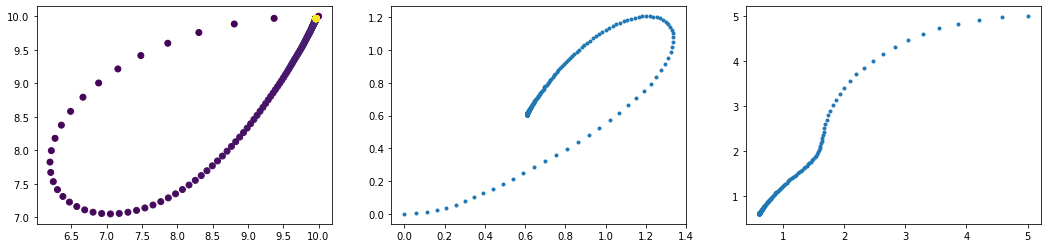

In [71]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].scatter(sol_repressilator.y[0],sol_repressilator.y[1],c=np.linspace(0,T,n));
ax[1].plot(sol_repressilator.y[2],sol_repressilator.y[3],'.');
ax[2].plot(sol_repressilator.y[4],sol_repressilator.y[5],'.');
"""
ax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');
ax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');
ax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');
"""

"\nax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');\nax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');\nax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');\n"

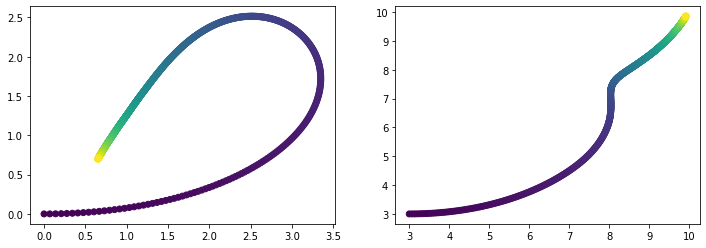

In [80]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(sol_toggle_switch.y[0],sol_toggle_switch.y[1],c=np.linspace(0,T,n));
ax[1].scatter(sol_toggle_switch.y[2],sol_toggle_switch.y[3],c=np.linspace(0,T,n));
"""
ax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');
ax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');
ax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');
"""

In [25]:
X=np.zeros((n,3,2))
X[:,0,:] = np.random.poisson(sol_repressilator.y[0:2,:].T)
X[:,1,:] = np.random.poisson(sol_repressilator.y[2:4,:].T)
X[:,2,:] = np.random.poisson(sol_repressilator.y[4:,:].T)

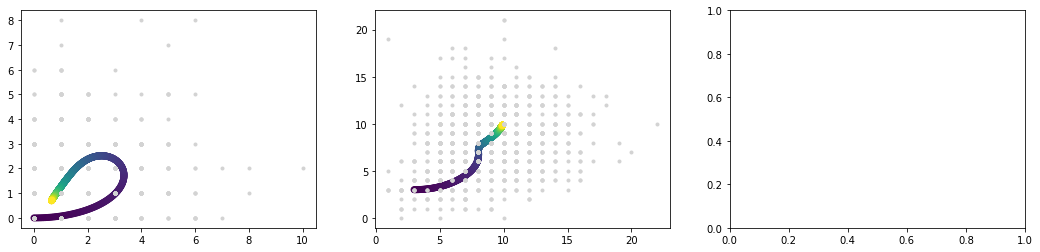

In [83]:
X=np.zeros((n,2,2))
X[:,0,:] = np.random.poisson(sol_toggle_switch.y[0:2,:].T)
X[:,1,:] = np.random.poisson(sol_toggle_switch.y[2:4,:].T)

fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].scatter(sol_toggle_switch.y[0],sol_toggle_switch.y[1],c=np.linspace(0,T,n));
ax[1].scatter(sol_toggle_switch.y[2],sol_toggle_switch.y[3],c=np.linspace(0,T,n));


ax[0].plot(X[:,0,0],X[:,0,1],'.',color='lightgray');
ax[1].plot(X[:,1,0],X[:,1,1],'.',color='lightgray');


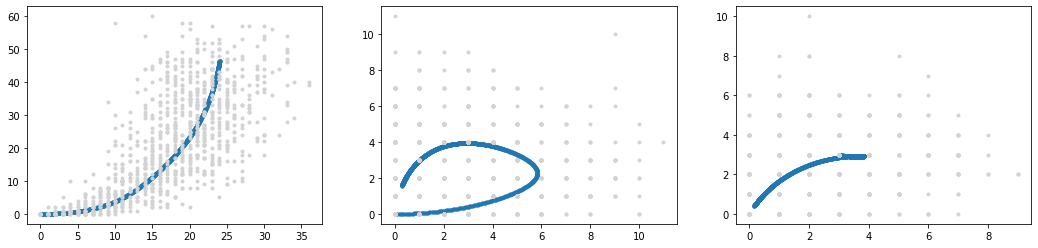

In [26]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].plot(sol_repressilator.y[0],sol_repressilator.y[1],'.');
ax[1].plot(sol_repressilator.y[2],sol_repressilator.y[3],'.');
ax[2].plot(sol_repressilator.y[4],sol_repressilator.y[5],'.');

ax[0].plot(X[:,0,0],X[:,0,1],'.',color='lightgray');
ax[1].plot(X[:,1,0],X[:,1,1],'.',color='lightgray');
ax[2].plot(X[:,2,0],X[:,2,1],'.',color='lightgray');

In [ ]:
Y=np.zeros((n,2,2))
Y_=np.zeros((n,2,2))
Y[:,0,:] = sol_toggle_switch.y[0:2,:].T
Y[:,1,:] = sol_toggle_switch.y[2:,:].T
Y_[:,0,:] = sol_piecewise.y[0:2,:].T
Y_[:,1,:] = sol_piecewise.y[2:,:].T

In [ ]:
logL = np.sum(X*np.log(Y+1e-6)-Y)

In [ ]:
logL_ = np.sum(X*np.log(Y_+1e-6)-Y_)

In [ ]:
logL, logL_

(19345.1814616582, 13911.119512963363)

In [ ]:
for seed in range(10):
  np.random.seed(seed)
  X=np.zeros((n,2,2))
  X[:,0,:] = np.random.poisson(sol_toggle_switch.y[0:2,:].T)
  X[:,1,:] = np.random.poisson(sol_toggle_switch.y[2:,:].T)
  logL = np.sum(X*np.log(Y+1e-6)-Y)
  logL_ = np.sum(X*np.log(Y_+1e-6)-Y_)
  print(logL, logL-logL_)


18880.03571626807 5324.7042063090485
19724.00254796687 5387.765836425984
19336.116476591138 5456.129096193097
19305.694539013144 5396.7025164842125
19103.44532761584 5333.563512339071
20141.930441571225 5433.368832422024
19846.408754534918 5228.998521898915
19225.844159742093 5459.7499646718425
19235.319949735633 5410.745083105829
19578.211082575617 5464.637577697415


## Fit toggle switch with piecewise

In [115]:
Q0 = np.diag(np.ones(n))

In [118]:
topo = np.array([[0,1]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species",verbose=1)
traj = traj.fit(X,Q=Q0[:,None],m=100,n_init=10,epoch=100,parallel=False,n_threads=1)

run method fit_warm_start


100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


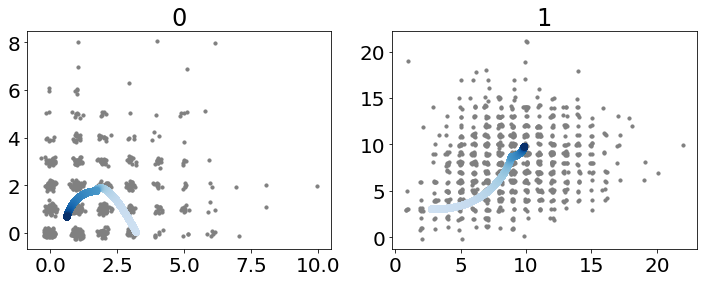

In [119]:
import matplotlib
matplotlib.rc('font', size=20)
fig, ax = plot_phase(traj,X=X,idx=np.arange(2))

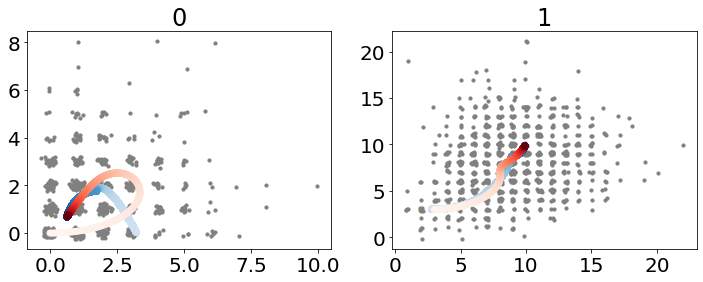

In [120]:
ax[0].scatter(sol_toggle_switch.y[0],sol_toggle_switch.y[1],c=np.linspace(0,T,n),cmap="Reds",alpha=1);
ax[1].scatter(sol_toggle_switch.y[2],sol_toggle_switch.y[3],c=np.linspace(0,T,n),cmap="Reds",alpha=1);
fig

<AxesSubplot:>

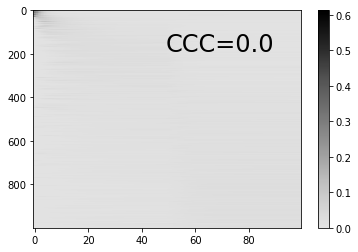

In [90]:
plot_t(traj,t=np.linspace(0,T,n))

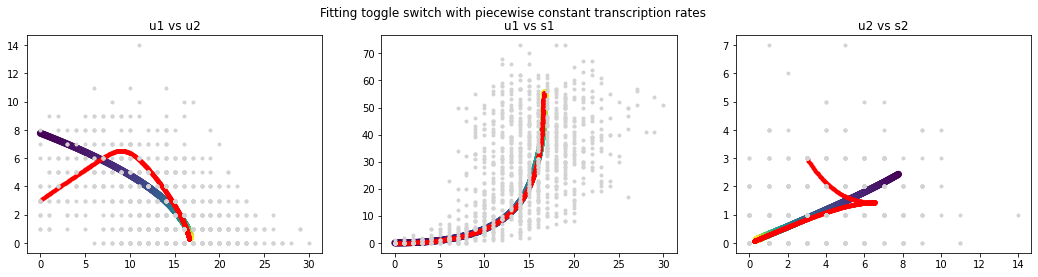

In [ ]:
t = traji.Q[:,0]@traji.t

fig, ax = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("Fitting toggle switch with piecewise constant transcription rates")

ax[0].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[2],'r.');
ax[0].set_title("u1 vs u2")
ax[1].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[1],'r.');
ax[1].set_title("u1 vs s1")
ax[2].plot(sol_toggle_switch.y[2],sol_toggle_switch.y[3],'r.');
ax[2].set_title("u2 vs s2")

ax[0].plot(X[:,0,0],X[:,1,0],'.',color='lightgray');
ax[1].plot(X[:,0,0],X[:,0,1],'.',color='lightgray');
ax[2].plot(X[:,1,0],X[:,1,1],'.',color='lightgray');

ax[0].scatter(Y_fit[:,0,0],Y_fit[:,1,0],c=t);
ax[1].scatter(Y_fit[:,0,0],Y_fit[:,0,1],c=t);
ax[2].scatter(Y_fit[:,1,0],Y_fit[:,1,1],c=t);

In [ ]:
theta_hat

array([[16.52106173, 16.83319367,  0.        ,  0.        ,  5.82877743,
         0.93046774],
       [ 0.18237896,  0.        ,  7.77194007,  2.43075787,  3.11594158,
        13.72520698]])

# Nothing out of nothing

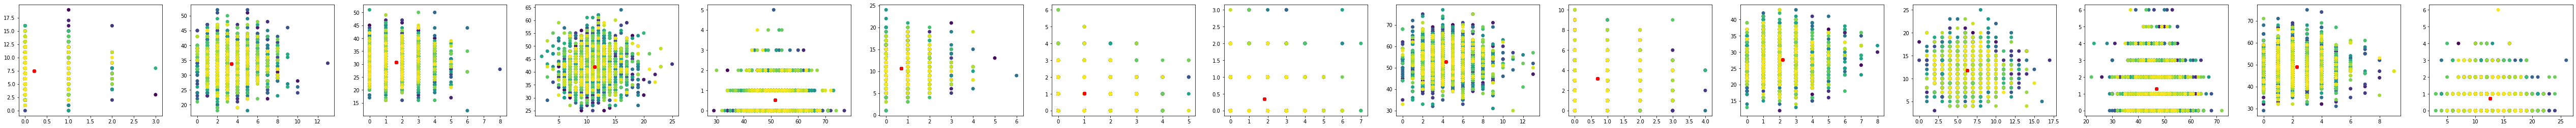

In [ ]:
#%% generate data
np.random.seed(84)
n = 1500
p = 15
Tau=[0,0.5]
tau=(0,0.5,1)
K=len(tau)-1
t=np.linspace(0, 1, n)

theta=np.zeros((p,K+4))
loga_max=4
logb_max=2
theta[:,0]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,1]=theta[:,0]
theta[:,-4]=theta[:,0]
theta[:,-3]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,-2]=1
theta[:,-1]=theta[:,-4]/theta[:,-3]

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1],c=t);
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c='r');

In [ ]:
weight=np.diag(v=[1]*n)
tau = (0,0.5,1)
penalty=0
theta_hat = update_theta(X,weight,tau,penalty,alternative=False,parallel=True,n_threads=2,theta0=None, bnd=1000)

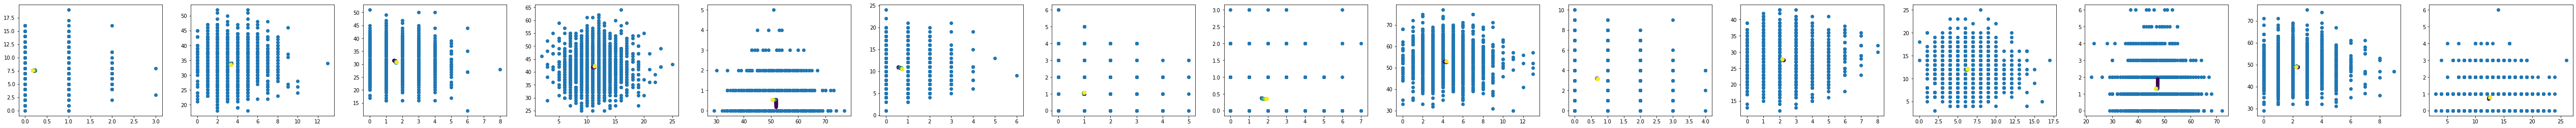

In [ ]:
t=np.linspace(0,1,n)
Y_fit = get_Y(theta_hat,t,tau)

fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1]);
    ax[i].scatter(Y_fit[:,i,0],Y_fit[:,i,1],c=t);

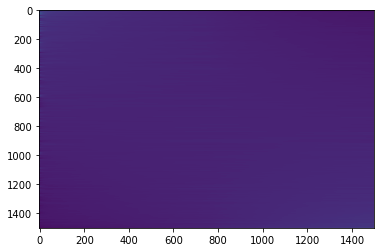

In [ ]:
new_weight = update_weight(X,theta_hat,tau,n)
plot_t(new_weight)

In [ ]:
weight=np.diag(v=[1]*n)
tau = (0,0.5,1)
penalty=n*0.001
theta_hat = update_theta(X,weight,tau,penalty,alternative=False,parallel=True,n_threads=2,theta0=None, bnd=1000)

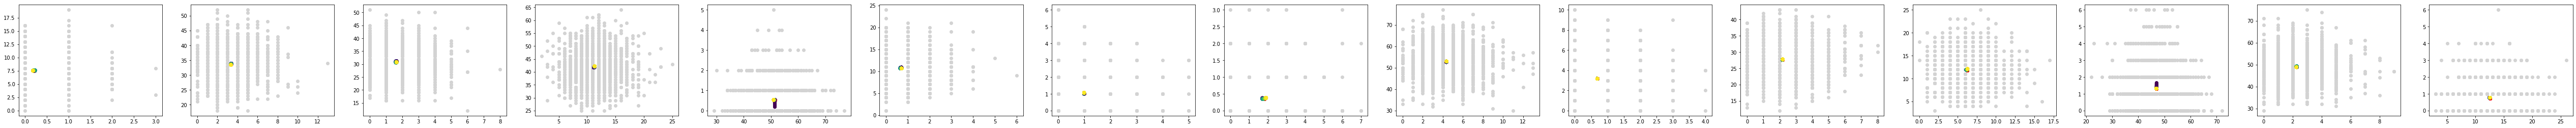

In [ ]:
t=np.linspace(0,1,n)
Y_fit = get_Y(theta_hat,t,tau)

fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1],c='lightgray');
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c='r');
    ax[i].scatter(Y_fit[:,i,0],Y_fit[:,i,1],c=t);

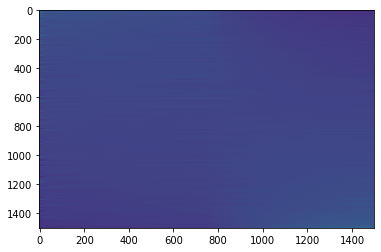

In [ ]:
new_weight = update_weight(X,theta_hat,tau,n)
plot_t(new_weight)